# Ejercicio en clase: Modelos de Ensamble

Este ejercicio tiene como objetivos:

* Aprender a entrenar modelos de ensamble por Votación y Random Forests
* Consolidar el conocimiento del proceso de preparación, ajuste y evaluación de modelos predictivos
* Practicar la optimización de hiperparámetros usando búsqueda aleatoria y búsqueda en grilla
* Visualizar las características más importantes identificadas por Random Forests

# Ensamble por votación manual

## Ejemplo de `scikit-learn`

Como inicio de este ejercicio tomemos una ilustración de la documentación de `scikit-learn`: [Plot the decision boundaries of a VotingClassifier](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html). En ella se diagrama las fronteras de decisión de un modelo de ensamble por votación, usando dos de las cuatro características del [Iris Flower Data Set](https://en.wikipedia.org/wiki/Iris_flower_data_set): largo del sépalo y largo del pétalo.

El conjunto de datos Iris contiene 50 muestras de cada una de tres posibles especies de Iris: *Iris setosa, Iris virginica* e *Iris versicolor*. Para cada muestra se tiene la medida en centímetros de cuatro características: largo y ancho de los pétalos y de los sépalos.

Este modelo por ensamble combina por votación las probabilidades de clase asignadas por tres clasificadores de base: un árbol de decisión (`DecisionTreeClassifier`), un modelo k-NN (`KNeighborsClassifier`), y una máquina de soporte vectorial con kernel gaussiano (`SVC`).

Se ha asignado manualmente a los modelos los pesos `[2, 1, 2]`, lo que significa que, al promediar las probabilidades obtenidas de los modelos, las probabilidades del árbol de decisión y de la máquina de soporte vectorial cuentan el doble que las del modelo k-NN.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


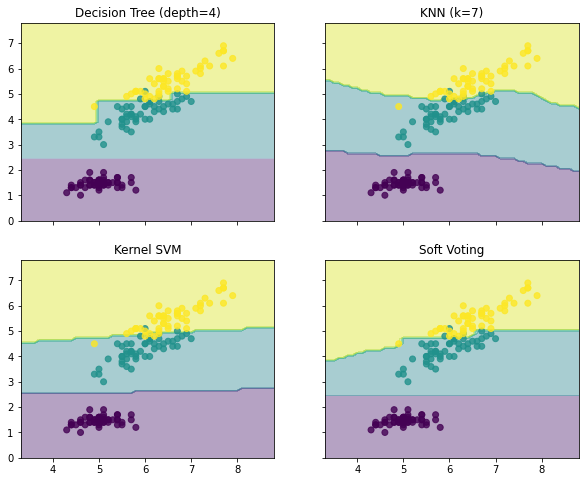

In [ ]:
# Tomado de http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
plt.style.use("default")
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [ ]:
# Ver las probabilidades asignadas por KNN (k=7) a cada clase en cada uno de los últimos 5 ejemplos del conjunto de entrenamiento
print(clf2.predict_proba(X[-5:]))

[[0.         0.14285714 0.85714286]
 [0.         0.14285714 0.85714286]
 [0.         0.14285714 0.85714286]
 [0.         0.         1.        ]
 [0.         0.14285714 0.85714286]]


## Evaluación del modelo de ensamble por votación manual

Observemos la exactitud *(accuracy)* de cada uno los modelos:

In [ ]:
print ("Exactitud del modelo de árbol de decisión     :", clf1.score(X, y))
print ("Exactitud del modelo de k-NN                  :", clf2.score(X, y))
print ("Exactitud del modelo SVM de kernel gaussiano  :", clf3.score(X, y))
print ("Exactitud del modelo de ensamble por votación :", eclf.score(X, y))


Exactitud del modelo de árbol de decisión     : 0.98
Exactitud del modelo de k-NN                  : 0.9666666666666667
Exactitud del modelo SVM de kernel gaussiano  : 0.9533333333333334
Exactitud del modelo de ensamble por votación : 0.98


¿A qué crees que se debe que en este caso no se haya llegado a un 100% de exactitud? (sesgo, varianza, error irreducible)

Dado que los modelos anteriores han sido entrenados en la totalidad de instancias del conjunto de datos Iris, ¿se puede decir que los valores anteriores son buenos indicadores del rendimiento que se tendrá fuera de la muestra (p.ej. en un conjunto de pruebas)?


# Ensamble por Bagging con Random Forests

En esta parte del ejercicio usaremos el conjunto de datos [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). A partir de un conjunto de características sobre cada pasajero se requiere predecir si sobrevivió o no a la tragedia. Ver la [descripción de los datos](https://www.kaggle.com/c/titanic/data)

En los siguientes pasos tenemos un ejemplo básico del proceso típico de aprendizaje de modelos predictivos.

## Obtención y carga de datos

In [ ]:
titanic_train = pd.read_csv('https://drive.google.com/uc?id=1KDFBLQjQW8lE3udxntinfx2K5V1npEGx&export=download')
titanic_test = pd.read_csv('https://drive.google.com/uc?id=1K5kDaWXAC36a0saM1d_FLEv0xFYUOvQy&export=download')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Algunas visualizaciones

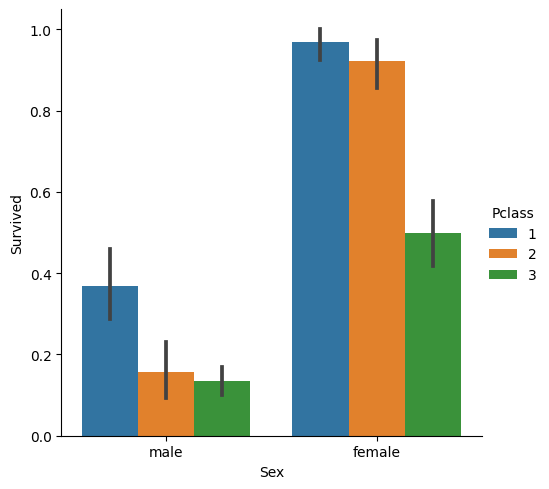

In [ ]:
plt.style.use("default")
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic_train);

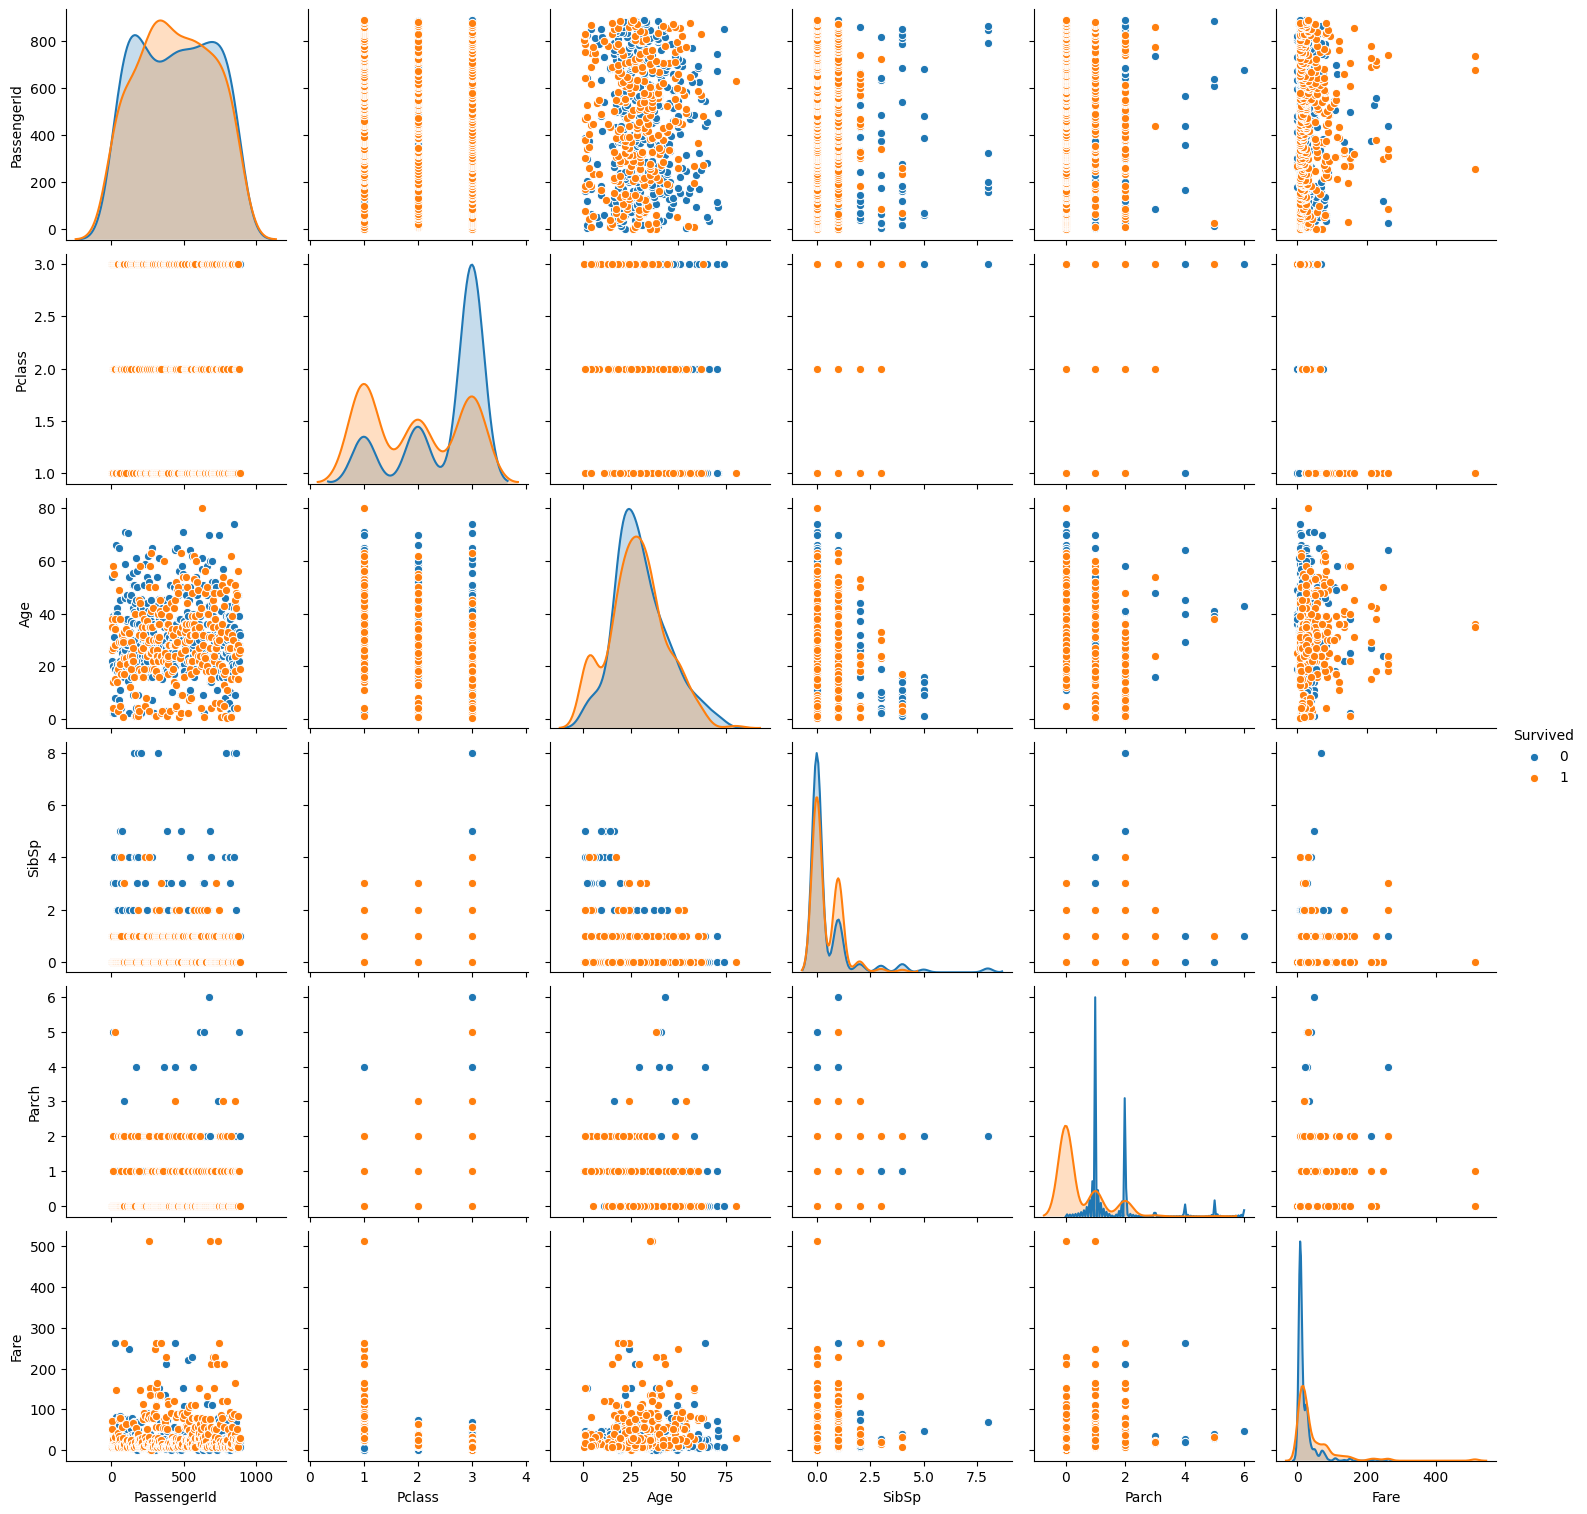

In [ ]:
sns.pairplot(titanic_train, hue="Survived");

## Preparación de los datos

`Pandas` nos permite seleccionar una columna como índice. En nuestro caso el índice es conveniente hacer con la columna `PassengerId`.

In [ ]:
titanic_train.set_index('PassengerId', inplace=True)
titanic_test.set_index('PassengerId', inplace=True)
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Lidiando con los valores faltantes

Usando un simple conteo en el conjunto de entrenamiento, podemos verificar que falta algunos valores para `Embarked`, `Age` y sobre todo `Cabin`.

In [ ]:
titanic_train.count()

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

En el conjunto de prueba, vemos que falta también un dato en `Fare`:

In [ ]:
titanic_test.count()

Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Ticket      418
Fare        417
Cabin        91
Embarked    418
dtype: int64

Hay diversas maneras de lidiar con valores faltantes. En este ejercicio haremos las siguientes opciones:

* `Embarked`: Sólo falta dos valores en el conjunto de entrenamiento. Imputaremos la moda (valor más frecuente). 

In [ ]:
# Sólo hay dos valores faltantes NaN. La moda (valor más frecuente) es 'S'
titanic_train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [ ]:
# Registramos el índice (PassengerId) de los dos casos, y luego mostramos ambos registros
embarked_NaN = titanic_train[titanic_train['Embarked'].isnull()].index
print('Los PassengerId en los que falta Embarked son: ', embarked_NaN.values)

titanic_train.loc[embarked_NaN]

Los PassengerId en los que falta Embarked son:  [ 62 830]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
# Calculamos la moda
embarked_moda = titanic_train['Embarked'].mode()[0]
print("La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es: ", embarked_moda)

La moda (valor más frecuente) de Embarked en el conjunto de entrenamiento es:  S


In [ ]:
# Imputamos la moda en los valores faltantes
titanic_train.loc[embarked_NaN,'Embarked'] = embarked_moda
titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


* `Age`: Incluiremos un campo booleano de `EdadDesconocida` y adicionalmente completaremos el valor con la mediana.

In [ ]:
# Creamos una columna para caracterizar los casos con edad desconocida
titanic_train['EdadDesconocida'] = titanic_train['Age'].isnull()
titanic_test['EdadDesconocida'] = titanic_test['Age'].isnull()

# Calculamos la mediana de Age y la imputamos en los valores faltantes de ambos conjuntos
# Mostramos cómo hacerlo con DataFrame.fillna()
age_mediana = titanic_train['Age'].median()
print("La mediana del campo Age en el conjunto de entrenamiento es: ", age_mediana)

titanic_train['Age'].fillna(age_mediana, inplace=True)
titanic_test['Age'].fillna(age_mediana, inplace=True)

La mediana del campo Age en el conjunto de entrenamiento es:  28.0


* `Fare`: Un solo caso, en el conjunto de prueba. Imputaremos la mediana del conjunto de entrenamiento.

In [ ]:
fare_mediana = titanic_train['Fare'].median()
print("La mediana del campo Fare en el conjunto de entrenamiento es: ", fare_mediana)

titanic_test['Fare'].fillna(fare_mediana, inplace=True)

La mediana del campo Fare en el conjunto de entrenamiento es:  14.4542


* `Cabin`: No usaremos la clase `Cabin`, severamente incompleta.

In [ ]:
titanic_train.drop(['Cabin'], axis=1, inplace=True)
titanic_test.drop(['Cabin'], axis=1, inplace=True)

### Selección de características

Ya hemos retirado la columna `Cabin`, severamente incompleta. Retiraremos también `Name` y `Ticket`, por ser campos irrelevantes para efectos de la predicción.

In [ ]:
titanic_train.drop(['Name','Ticket'], axis=1, inplace=True)
titanic_test.drop(['Name','Ticket'], axis=1, inplace=True)

Podemos añadir otras meta-características. Por ejemplo, podríamos crear una columna `ViajaSolo` cuando no el pasajero no viajó  con ningún familiar: 0 `SibSp` (viaja con hermanos o cónyuge) y 0 `Parch` (viaja con padres o hijos).

In [ ]:
titanic_train['ViajaSolo'] = ((titanic_train['SibSp'] + titanic_train['Parch']) == 0)
titanic_test['ViajaSolo'] = ((titanic_test['SibSp'] + titanic_test['Parch']) == 0)
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False,False
2,1,1,female,38.0,1,0,71.2833,C,False,False
3,1,3,female,26.0,0,0,7.9250,S,False,True
4,1,1,female,35.0,1,0,53.1000,S,False,False
5,0,3,male,35.0,0,0,8.0500,S,False,True


In [ ]:
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,False,True
893,3,female,47.0,1,0,7.0000,S,False,False
894,2,male,62.0,0,0,9.6875,Q,False,True
895,3,male,27.0,0,0,8.6625,S,False,True
896,3,female,22.0,1,1,12.2875,S,False,False


Añade las columnas `MenorDeEdad` y `AdultoMayor`. Considera como menor de edad a todos aquellos menores de 18.0 años. Considera Adulto Mayor a los mayores de 55.0 años. Hazlo tanto en el conjunto de entrenamiento como en el de pruebas.

In [ ]:
## COMPLETAR
titanic_train['MenorDeEdad'] = (titanic_train['Age'] < 18.0)
titanic_test['MenorDeEdad'] = (titanic_test['Age'] < 18.0)

titanic_train['AdultoMayor'] = (titanic_train['Age'] > 55.0)
titanic_test['AdultoMayor'] = (titanic_test['Age'] > 55.0)

**Pregunta 3:** ¿Cuántos menores de edad hay en el conjunto de entrenamiento?

In [ ]:
len(titanic_train['MenorDeEdad'])
titanic_train['MenorDeEdad'].count()

891

**Pregunta 4:** ¿Cuántos adultos mayores hay en el conjunto de pruebas?

In [ ]:
len(titanic_train['AdultoMayor'])
titanic_train['AdultoMayor'].count()

891

### Codificación de variables categóricas

Tenemos también tres variables categóricas (`Sex`, `Pclass` y `Embarked`). Las convertiremos en datos numéricos para que facilitar su entrenamiento por cualquier modelo.

* `Sex`: la podemos reemplazar por un valor binario `EsMujer` (0 = hombre; 1 = mujer). 

In [ ]:
titanic_train['EsMujer'] = (titanic_train['Sex'] == 'female')
titanic_test['EsMujer'] = (titanic_test['Sex'] == 'female')

titanic_train.drop(['Sex'], axis=1, inplace=True)
titanic_test.drop(['Sex'], axis=1, inplace=True)

* `Pclass` y `Embarked`: Usaremos *one-hot encoding* con la función `DataFrame.get_dummies` de `pandas`. 

  `Pclass` es la clase en la que viajó el pasajero (1 = primera clase; 2 = segunda clase; 3 = tercera clase).

  `Embarked` es el puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton).

  Observa que `Pclass` es categórica no obstante haya sido representada con una codificación numérica.

In [ ]:
cols_categoricas = ['Pclass','Embarked']

titanic_train = pd.get_dummies(titanic_train, columns=cols_categoricas)
titanic_test = pd.get_dummies(titanic_test, columns=cols_categoricas)

titanic_train.head()

,Survived,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,False,False,False,0,0,1,0,0,1
2,1,38.0,1,0,71.2833,False,False,False,False,True,1,0,0,1,0,0
3,1,26.0,0,0,7.9250,False,True,False,False,True,0,0,1,0,0,1
4,1,35.0,1,0,53.1000,False,False,False,False,True,1,0,0,0,0,1
5,0,35.0,0,0,8.0500,False,True,False,False,False,0,0,1,0,0,1


In [ ]:
titanic_test.head()

,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,False,True,False,False,False,0,0,1,0,1,0
893,47.0,1,0,7.0000,False,False,False,False,True,0,0,1,0,0,1
894,62.0,0,0,9.6875,False,True,False,True,False,0,1,0,0,1,0
895,27.0,0,0,8.6625,False,True,False,False,False,0,0,1,0,0,1
896,22.0,1,1,12.2875,False,False,False,False,True,0,0,1,0,0,1


## Separación de conjunto para validación

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val = titanic_train.drop('Survived', axis=1)
y_train_val = titanic_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

## Entrenamiento de Random Forests

Probemos primero entrenando un modelo Random Forest con los parámetros que trae por defecto.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train, y_train)

print('Exactitud del modelo inicial en entrenamiento:', rf.score(X_train, y_train))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', rf.oob_score_)
print('Exactitud del modelo inicial en validación:', rf.score(X_val, y_val))

Exactitud del modelo inicial en entrenamiento: 0.9817415730337079
Exactitud del modelo inicial en entrenamiento (Out of Bag): 0.7949438202247191
Exactitud del modelo inicial en validación: 0.8156424581005587


### Búsqueda aleatoria de hiperparámetros

El clasificador de Random Forest tiene diversos parámetros que pueden ser optimizados. Se puede ver la documentación de [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Los principales hiperparámetros de Random Forest son:
- `n_estimators` -- el número de modelos base (árboles) a entrenar
- `max_features` -- el número de características a considerar en cada partición de los árboles
- `max_depth` -- la profundidad máxima de los árboles
- `min_samples_leaf` -- el numero mínimo de muestras que deben quedar en cada hoja del árbol

Para identificar los mejores valores de los hiperparámetros usaremos primero búsqueda aleatoria y luego búsqueda en grilla.

In [ ]:
from pprint import pprint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

print()
print('Si se probara todas las combinaciones se requeriría entrenar', 
      len(random_grid['n_estimators']) *
      len(random_grid['max_features']) *
      len(random_grid['max_depth']) *
      len(random_grid['min_samples_leaf']),
      'modelos'
      )

Los valores a probar en la búsqueda aleatoria son:
{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 8, 10, 12, None],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Si se probara todas las combinaciones se requeriría entrenar 1800 modelos


Probaremos entrenando sólo un 2% de las combinaciones posibles, es decir, 18. (Se recomienda probar al menos un 10%)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 18, 
                               cv = 3,          # Validación cruzada 3-fold
                               verbose=2, 
                               random_state=0, 
                               n_jobs = -1      # Paralelizar en todos los cores disponibles
                               )
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random_best = rf_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_random.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rf_random_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', rf_random_best.oob_score_)
print('Exactitud luego de búsqueda aleatoria en validación:', rf_random_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': 50,
 'max_features': 10,
 'min_samples_leaf': 4,
 'n_estimators': 1000}

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8904494382022472
Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag): 0.827247191011236
Exactitud luego de búsqueda aleatoria en validación: 0.8435754189944135


In [ ]:
max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

segundo_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda por grilla son:')
pprint(segundo_grid)

Los valores a probar en la búsqueda por grilla son:
{'max_depth': [57, 60, 63],
 'max_features': [9, 10, 11],
 'min_samples_leaf': [4],
 'n_estimators': [1200]}


In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(oob_score = True)
rf_grid = GridSearchCV(estimator = rf, 
                        param_grid = segundo_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   55.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                                 

In [ ]:
rf_grid_best = rf_grid.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_grid.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', rf_grid_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag):', rf_grid_best.oob_score_)
print('Exactitud luego de búsqueda en grilla en validación:', rf_grid_best.score(X_val, y_val))

Los hiperparámetros del mejor modelo son:
{'max_depth': 60,
 'max_features': 9,
 'min_samples_leaf': 4,
 'n_estimators': 1200}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8876404494382022
Exactitud luego de búsqueda en grilla en entrenamiento (Out of Bag): 0.8202247191011236
Exactitud luego de búsqueda en grilla en validación: 0.8435754189944135


### Curva ROC

AUC = 0.8953886693017128


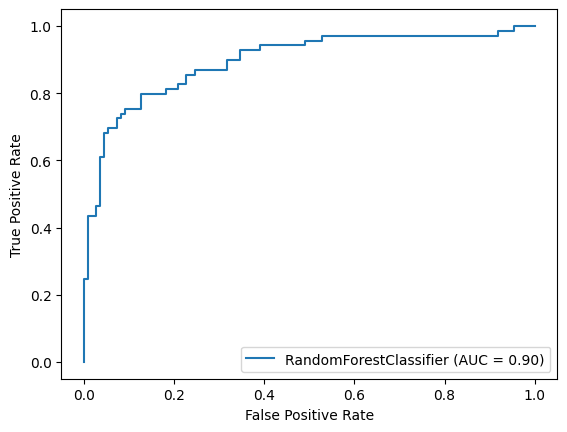

In [ ]:
from sklearn import metrics

y_pred_val = rf_grid_best.predict_proba(X_val)[:,1]
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)
print('AUC =', auc_roc)

metrics.plot_roc_curve(rf_grid_best, X_val, y_val)
plt.show()                 

## Visualización de las características más importantes



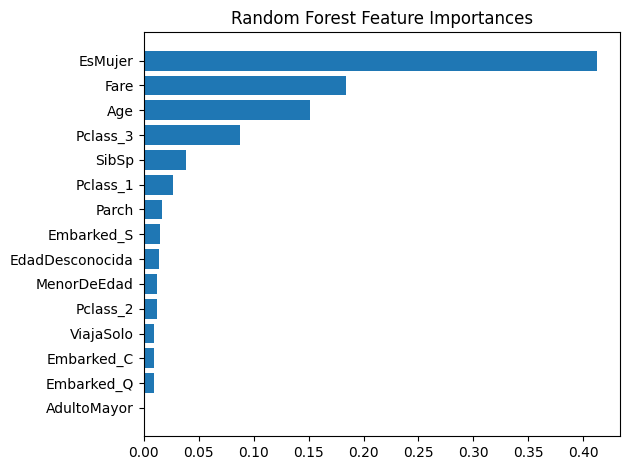

In [ ]:
feature_names = X_train.columns.values
tree_feature_importances = rf_grid_best.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

# Otros modelos de ensamble

Prueba a entrenar ensambles con otras [estrategias](https://scikit-learn.org/stable/modules/ensemble.html#). Puedes intentar, por ejemplo, con [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting), [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) ([ejemplos](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py)\) o [Apilamiento](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization).

## Stacked generalization

In [ ]:
 from sklearn.linear_model import RidgeCV, LassoCV
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.svm import LinearSVC
 from sklearn.linear_model import LogisticRegression
 from sklearn.preprocessing import StandardScaler
 from sklearn.ensemble import StackingClassifier
 from sklearn.pipeline import make_pipeline

In [ ]:
estimators = [
              ('rf', RandomForestClassifier(n_estimators=12, random_state=42)),
               ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))
               ]

In [ ]:
stack_model = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
     )

In [ ]:
stack_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                     

In [ ]:
y_pred = stack_model.predict(X_val)

In [ ]:
print('Exactitud del modelo Stacked generalization en entrenamiento:', stack_model.score(X_train, y_train))
print('Exactitud del modelo Stacked generalization en validación:', stack_model.score(X_val, y_val))

Exactitud del modelo Stacked generalization en entrenamiento: 0.8834269662921348
Exactitud del modelo Stacked generalization en validación: 0.8100558659217877


### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_leaf': min_samples_leaf}

rscv_stack = RandomizedSearchCV(
    estimator=stack_model, 
    param_distributions=random_grid,
    n_iter = 18, 
    cv = 3,          # Validación cruzada 3-fold
    verbose=2, 
    random_state=0, 
    n_jobs = -1      # Paralelizar en todos los cores disponibles
)

In [ ]:
rscv_stack.fit(X_train, y_train)

rscv_stack_best = rscv_stack.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rscv_stack.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=18. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Los hiperparámetros del mejor modelo son:
{'rf__max_depth': 57,
 'rf__max_features': 9,
 'rf__min_samples_leaf': 4,
 'rf__n_estimators': 1200}


In [ ]:
print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rscv_stack_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', rscv_stack_best.score(X_val, y_val))

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.8665730337078652
Exactitud luego de búsqueda aleatoria en validación: 0.8324022346368715


### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

segundo_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_leaf': min_samples_leaf}


gscv_stack = GridSearchCV(estimator = stack_model, 
                        param_grid = segundo_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )

In [ ]:
gscv_stack.fit(X_train, y_train)

gscv_stack_best = gscv_stack.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(gscv_stack.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', gscv_stack_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en validación:', gscv_stack_best.score(X_val, y_val))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/sv

Los hiperparámetros del mejor modelo son:
{'rf__max_depth': 57,
 'rf__max_features': 9,
 'rf__min_samples_leaf': 4,
 'rf__n_estimators': 1200}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.8665730337078652
Exactitud luego de búsqueda en grilla en validación: 0.8324022346368715


### Curva ROC Stacked generalization

AUC = 0.8982872200263505


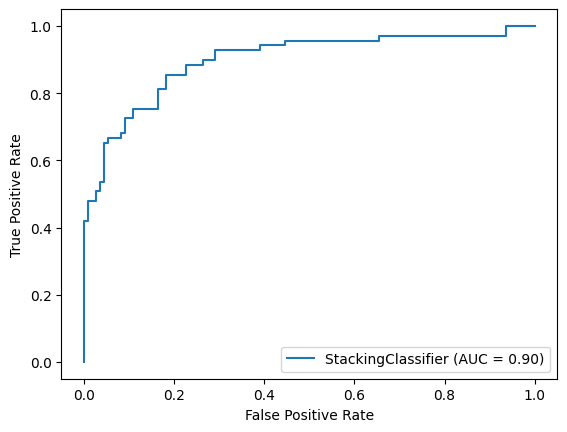

In [ ]:
from sklearn import metrics

y_pred_val = gscv_stack_best.predict_proba(X_val)[:,1]
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)
print('AUC =', auc_roc)

metrics.plot_roc_curve(gscv_stack_best, X_val, y_val)
plt.show()      

## XGBOOST

In [ ]:
import xgboost as xgb

In [ ]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_train, y_train)])

[0]	validation_0-auc:0.862391
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.862391
[2]	validation_0-auc:0.862429
[3]	validation_0-auc:0.865992
[4]	validation_0-auc:0.867047
[5]	validation_0-auc:0.868311
[6]	validation_0-auc:0.868478
[7]	validation_0-auc:0.868662
[8]	validation_0-auc:0.869158
[9]	validation_0-auc:0.875804
[10]	validation_0-auc:0.876455
[11]	validation_0-auc:0.877431
[12]	validation_0-auc:0.879279
[13]	validation_0-auc:0.879622
[14]	validation_0-auc:0.882308
[15]	validation_0-auc:0.883977
[16]	validation_0-auc:0.885333
[17]	validation_0-auc:0.885917
[18]	validation_0-auc:0.8859
[19]	validation_0-auc:0.888687
[20]	validation_0-auc:0.887828
[21]	validation_0-auc:0.887782
[22]	validation_0-auc:0.889547
[23]	validation_0-auc:0.8892
[24]	validation_0-auc:0.88963
[25]	validation_0-auc:0.89049
[26]	validation_0-auc:0.892396
[27]	validation_0-auc:0.893297
[28]	validation_0-auc:0.894428
[29]	validation_0-auc:0.894411
[30]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print('Exactitud del modelo XGBOOST en entrenamiento:', xgboost_model.score(X_train, y_train))
print('Exactitud del modelo XGBOOST en validación:', xgboost_model.score(X_val, y_val))

Exactitud del modelo XGBOOST en entrenamiento: 0.875
Exactitud del modelo XGBOOST en validación: 0.8268156424581006


### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

rscv_xgboost = RandomizedSearchCV(
    estimator=xgboost_model, 
    param_distributions=random_grid,
    n_iter = 18, 
    cv = 3,          # Validación cruzada 3-fold
    verbose=2, 
    random_state=0, 
    n_jobs = -1      # Paralelizar en todos los cores disponibles
)

In [ ]:
rscv_xgboost.fit(X_train, y_train)

rscv_xgboost_best = rscv_xgboost.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rscv_xgboost.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rscv_xgboost_best.score(X_train, y_train))
print('Exactitud luego de búsqueda aleatoria en validación:', rscv_xgboost_best.score(X_val, y_val))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=18. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   19.1s finished


Los hiperparámetros del mejor modelo son:
{'max_depth': 57,
 'max_features': 9,
 'min_samples_leaf': 4,
 'n_estimators': 1200}

Exactitud luego de búsqueda aleatoria en entrenamiento: 0.9817415730337079
Exactitud luego de búsqueda aleatoria en validación: 0.8324022346368715


### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

segundo_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}


gscv_xgboost = GridSearchCV(estimator = xgboost_model, 
                        param_grid = segundo_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )

In [ ]:
gscv_xgboost.fit(X_train, y_train)

gscv_xgboost_best = gscv_xgboost.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(gscv_xgboost.best_params_)
print()

print('Exactitud luego de búsqueda en grilla en entrenamiento:', gscv_xgboost_best.score(X_train, y_train))
print('Exactitud luego de búsqueda en grilla en validación:', gscv_xgboost_best.score(X_val, y_val))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   19.1s finished


Los hiperparámetros del mejor modelo son:
{'max_depth': 57,
 'max_features': 9,
 'min_samples_leaf': 4,
 'n_estimators': 1200}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9817415730337079
Exactitud luego de búsqueda en grilla en validación: 0.8324022346368715


### Curva ROC XGBOOST


AUC = 0.8744400527009222


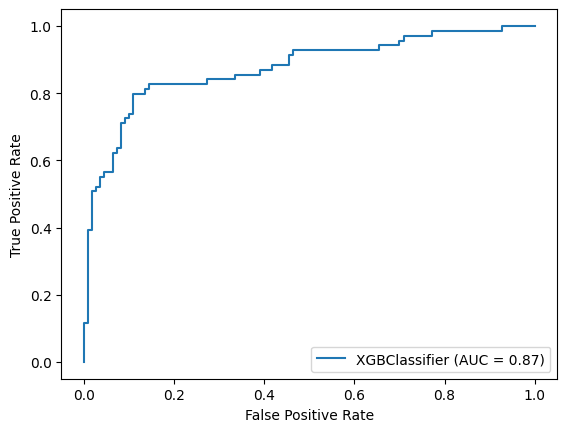

In [ ]:
from sklearn import metrics

y_pred_val = gscv_xgboost_best.predict_proba(X_val)[:,1]
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)
print('AUC =', auc_roc)

metrics.plot_roc_curve(gscv_xgboost_best, X_val, y_val)
plt.show()     